<a href="https://colab.research.google.com/github/dKC-7000001/Air-Passenger-Forecasting-using-Arima/blob/main/Air_Passengers_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/Kaggle_Key/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d naveengowda16/time-series-analysis-arima-model

  0% 0.00/771 [00:00<?, ?B/s]
100% 771/771 [00:00<00:00, 505kB/s]


In [ ]:
! unzip time-series-analysis-arima-model.zip

Archive:  time-series-analysis-arima-model.zip
  inflating: AirPassengers.csv       


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv('AirPassengers.csv')

In [ ]:
df1.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df1.describe(include='all')

,Month,#Passengers
count,144,144.000000
unique,144,NaN
top,1949-01,NaN
freq,1,NaN
mean,NaN,280.305556
std,NaN,119.975188
min,NaN,104.000000
25%,NaN,180.000000
50%,NaN,265.500000
75%,NaN,360.500000


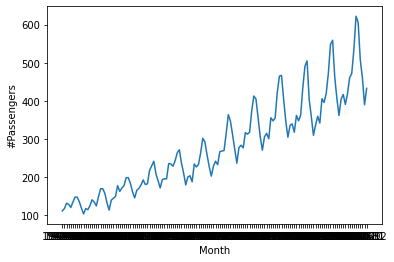

In [ ]:
sns.lineplot(x='Month', y='#Passengers', data=df1)

In [ ]:
import plotly.express as px

#df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df1, x="Month", y="#Passengers", title='Air Passengers')
fig.show()

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



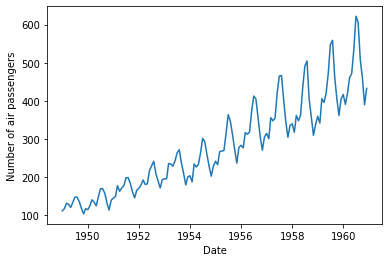

In [ ]:
df = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col = ['Month'])
df.head()
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df)

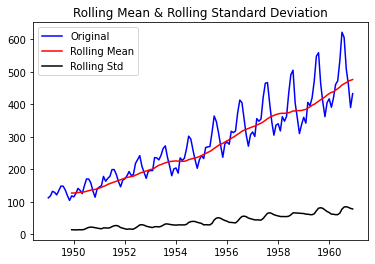

In [ ]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
result = adfuller(df['#Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.8273719403667943
p-value: 0.9920653980124213
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.
Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.

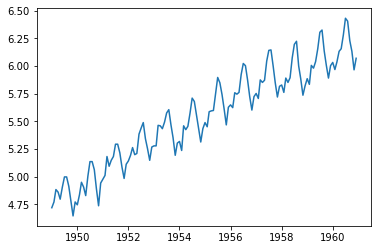

In [ ]:
df_log = np.log(df)
plt.plot(df_log)

In [ ]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['#Passengers'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

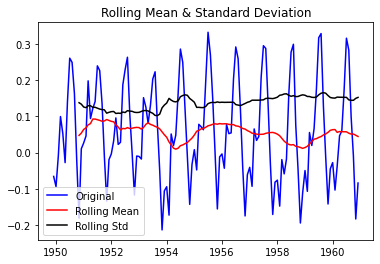

ADF Statistic: -3.1661123349759523
p-value: 0.022031951757343297
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [ ]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

As we can see, after subtracting the mean, the rolling mean and standard deviation are approximately horizontal. The p-value is below the threshold of 0.05 and the ADF Statistic is close to the critical values. Therefore, the time series is stationary.
Applying exponential decay is another way of transforming a time series such that it is stationary.

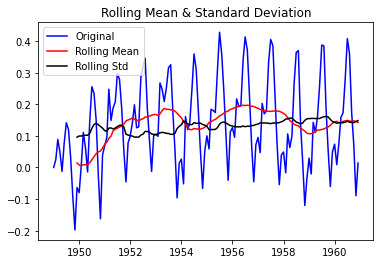

ADF Statistic: -3.603614215945144
p-value: 0.00569230643719157
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [ ]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

Exponential decay performed worse than subtracting the rolling mean. However, it is still more stationary than the original.
Let’s try one more method to determine whether an even better solution exists. When applying time shifting, we subtract every the point by the one that preceded it.
null, (x1−x0), (x2−x1), (x3−x2), (x4−x3), …, (xn−xn−1)

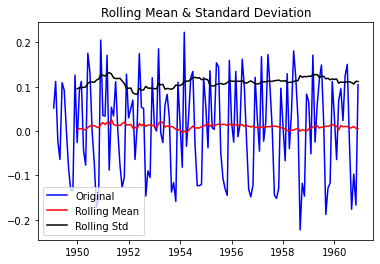

ADF Statistic: -2.721864349884489
p-value: 0.07033059668593976
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


In [ ]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

AutoRegressive Model (AR)
Autoregressive models operate under the premise that past values have an effect on current values. AR models are commonly used in analyzing nature, economics, and other time-varying processes. As long as the assumption holds, we can build a linear regression model that attempts to predict value of a dependent variable today, given the values it had on previous days.

The order of the AR model corresponds to the number of days incorporated in the formula.

Moving Average Model (MA)
Assumes the value of the dependent variable on the current day depends on the previous days error terms. The formula can be expressed as:

You’ll also come across the equation written as:

where μ is the mean of the series, the θ1, …, θq are the parameters of the model and the εt, εt−1,…, εt−q are white noise error terms. The value of q is called the order of the MA model.
Auto Regressive Moving Average (ARMA)
The ARMA model is simply the combination of the AR and MA models.

AutoRegressive Integrated Moving Average Model (ARIMA)
The ARIMA (aka Box-Jenkins) model adds differencing to an ARMA model. Differencing subtracts the current value from the previous and can be used to transform a time series into one that’s stationary. For example, first-order differencing addresses linear trends, and employs the transformation zi = yi — yi-1. Second-order differencing addresses quadratic trends and employs a first-order difference of a first-order difference, namely zi = (yi — yi-1) — (yi-1 — yi-2), and so on.


Three integers (p, d, q) are typically used to parametrize ARIMA models.
p: number of autoregressive terms (AR order)
d: number of nonseasonal differences (differencing order)
q: number of moving-average terms (MA order)
Auto Correlation Function (ACF)
The correlation between the observations at the current point in time and the observations at all previous points in time. We can use ACF to determine the optimal number of MA terms. The number of terms determines the order of the model.
Partial Auto Correlation Function (PACF)
As the name implies, PACF is a subset of ACF. PACF expresses the correlation between observations made at two points in time while accounting for any influence from other data points. We can use PACF to determine the optimal number of terms to use in the AR model. The number of terms determines the order of the model.
Let’s take a look at an example. Recall, that PACF can be used to figure out the best order of the AR model. The horizontal blue dashed lines represent the significance thresholds. The vertical lines represent the ACF and PACF values at in point in time. Only the vertical lines that exceed the horizontal lines are considered significant.

Thus, we’d use the preceding two days in the autoregression equation.
Recall, that ACF can be used to figure out the best order of the MA model.

Thus, we’d only use yesterday in the moving average equation.
Going back to our example, we can create and fit an ARIMA model with AR of order 2, differencing of order 1 and MA of order 2.
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

Then, we can see how the model compares to the original time series.
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

Given that we have data going for every month going back 12 years and want to forecast the number of passengers for the next 10 years, we use (12 x12)+ (12 x 10) = 264.
results.plot_predict(1,264)

Final Thoughts
In the domain of machine learning, there is a collection techniques for manipulating and interpreting variables that depend on time. Among these include ARIMA which can remove the trend component in order to accurately predict future values.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



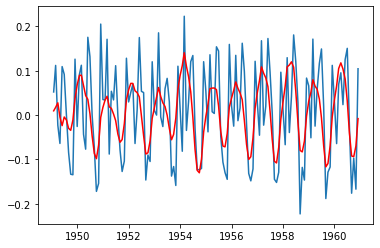

In [ ]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

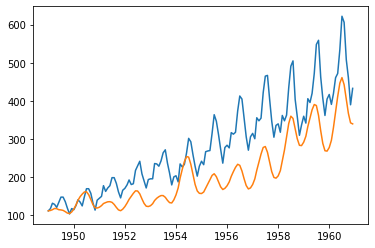

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['#Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

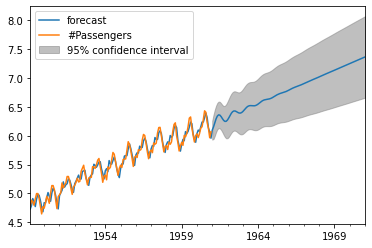

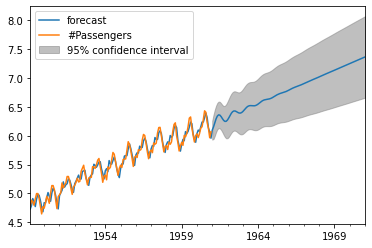

In [ ]:
results.plot_predict(1,264)

Final Thoughts
In the domain of machine learning, there is a collection techniques for manipulating and interpreting variables that depend on time. Among these include ARIMA which can remove the trend component in order to accurately predict future values.